In [1]:
import argparse
import os

import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import matplotlib.pyplot as plt
import numpy as np

from conf.model_config import ModelType
from conf.hardware_config import DeviceType

In [3]:
import os
import pandas as pd
import re

# Define target models
target_models = ['DEEPSEEK_V3'] + [f'QWEN3_235B_E{e}_L{l}' for e in [2,4,6,8,12,16,32] for l in [30,50,70,94]]
# target_models = ['DEEPSEEK_V3', 'M8', 'QWEN3_235B']

def merge_data(base_dirs, model_names, mode_name, micro_batch_num=None):
    all_dfs = []
    print(f'Processing {mode_name} mode...')
    
    for model_name in model_names:
        # Pattern differs slightly depending on if directory structure is same
        pattern = re.compile(r'ASCENDA3_Pod-' + model_name + r'-tpot(\d+)-kv_len(\d+)\.csv')
        
        for target_dir in base_dirs:
            if not os.path.exists(target_dir):
                print(f'Warning: Directory not found: {target_dir}')
                continue
                
            files = os.listdir(target_dir)
            count = 0
            for f in files:
                match = pattern.match(f)
                if match:
                    tpot = int(match.group(1))
                    kv_len = int(match.group(2))
                    full_path = os.path.join(target_dir, f)
                    try:
                        df = pd.read_csv(full_path)
                        df['tpot'] = tpot
                        df['kv_len'] = kv_len
                        df['mode'] = mode_name
                        df['model_name'] = model_name
                        # Round all float columns to 2 decimal places
                        df = df.round(2)
                        # Extract mbn from directory path if multiple passed
                        if 'mbn2' in target_dir:
                            df['micro_batch_num'] = 2
                        elif 'mbn3' in target_dir:
                            df['micro_batch_num'] = 3
                        else:
                            df['micro_batch_num'] = micro_batch_num
                        all_dfs.append(df)
                        count += 1
                    except Exception as e:
                        print(f'Error reading {f}: {e}')
            print(f'  Found {count} files for {model_name} in {target_dir}')
            
    if all_dfs:
        merged_df = pd.concat(all_dfs, ignore_index=True)
        return merged_df
    return pd.DataFrame()

# 1. AFD Mode Data (combining mbn2 and mbn3 results)
afd_dirs = ['data/afd/mbn2/best', 'data/afd/mbn3/best']
df_afd = merge_data(afd_dirs, target_models, 'AFD')

# 2. DeepEP Mode Data
deepep_dirs = ['data/deepep']  # Assuming deepep results are here based on file structure
df_deepep = merge_data(deepep_dirs, target_models, 'DeepEP', micro_batch_num=1)

print(f'\nAFD DataFrame shape: {df_afd.shape}')
print(f'DeepEP DataFrame shape: {df_deepep.shape}')

# Optional: Save to CSV
# df_afd.to_csv('merged_afd_all_models.csv', index=False)
# df_deepep.to_csv('merged_deepep_all_models.csv', index=False)


Processing AFD mode...
  Found 0 files for DEEPSEEK_V3 in data/afd/mbn2/best
  Found 0 files for DEEPSEEK_V3 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E2_L30 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E2_L30 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E2_L50 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E2_L50 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E2_L70 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E2_L70 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E2_L94 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E2_L94 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E4_L30 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E4_L30 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E4_L50 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E4_L50 in data/afd/mbn3/best
  Found 0 files for QWEN3_235B_E4_L70 in data/afd/mbn2/best
  Found 0 files for QWEN3_235B_E4_L70 in data/afd/mbn3/best
  Found 0 files for QWEN3_235

/var/folders/x4/lt_l8tqs4f72shk9j2pg9d3h0000gn/T/ipykernel_41861/3670949457.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(all_dfs, ignore_index=True)


In [4]:
df_afd[(df_afd['model_name'] == "QWEN3_235B_E8_L94") & (df_afd['attn_die'] == 3 * df_afd['ffn_die']) & (df_afd['micro_batch_num'] == 3)& (df_afd['tpot'] == 150)]

,attn_bs,ffn_bs,kv_len,attn_die,ffn_die,total_die,attn_time,moe_time,dispatch_time,combine_time,commu_time,e2e_time,e2e_time_per_dense_layer,e2e_time_per_moe_layer,throughput,tpot,mode,model_name,micro_batch_num
4416,97,2328.00,2048,1152,384,1536,794.11,378.12,507.46,1014.93,1522.39,253.29,0.00,2694.62,1464.80,150,AFD,QWEN3_235B_E8_L94,3
5080,29,696.00,16384,96,32,128,882.51,185.72,151.72,303.43,455.15,248.87,0.00,2647.52,445.72,150,AFD,QWEN3_235B_E8_L94,3
5832,81,1944.00,4096,96,32,128,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
5836,81,1944.00,4096,144,48,192,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
5840,81,1944.00,4096,192,64,256,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
5844,81,1944.00,4096,240,80,320,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
5848,81,1944.00,4096,288,96,384,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
5852,81,1944.00,4096,336,112,448,900.22,315.75,423.76,847.52,1271.28,253.86,0.00,2700.67,1220.44,150,AFD,QWEN3_235B_E8_L94,3
6208,4,96.00,131072,96,32,128,863.13,84.32,20.93,41.85,62.78,243.40,0.00,2589.39,62.86,150,AFD,QWEN3_235B_E8_L94,3
7148,51,1224.00,8192,96,32,128,891.85,261.67,266.81,533.62,800.43,251.50,0.00,2675.55,775.64,150,AFD,QWEN3_235B_E8_L94,3


In [5]:
def compare_model_throughput(model_name, total_die_filter=None, micro_batch_num_filter=None):
    # 1. Filter DataFrames by model_name
    afd_subset = df_afd[df_afd['model_name'] == model_name].copy()
    deepep_subset = df_deepep[df_deepep['model_name'] == model_name].copy()
    
    # 2. Apply micro_batch_num filter if provided
    if micro_batch_num_filter is not None:
        afd_subset = afd_subset[afd_subset['micro_batch_num'] == micro_batch_num_filter]
    
    # 3. Apply total_die filter if provided
    if total_die_filter is not None:
        afd_subset = afd_subset[afd_subset['total_die'] == total_die_filter]
        deepep_subset = deepep_subset[deepep_subset['total_die'] == total_die_filter]
    
    # 4. Pick best AFD configuration
    # Sort by throughput desc and take the first one for each unique config (total_die, kv_len, tpot)
    afd_best = afd_subset.sort_values('throughput', ascending=False).drop_duplicates(
        subset=['total_die', 'kv_len', 'tpot']
    )
    
    # 5. Prepare for Merge
    # Include micro_batch_num, attn_die, ffn_die in the selection
    afd_renamed = afd_best[['model_name', 'total_die', 'kv_len', 'tpot', 'micro_batch_num', 'attn_die', 'ffn_die', 'throughput', 'attn_bs', 'e2e_time']].rename(
        columns={'throughput': 'throughput_afd', 'attn_bs': 'afd_attn_bs_per_mb', 'e2e_time': 'afd_e2e_time'}
    )
    
    deepep_renamed = deepep_subset[['model_name', 'total_die', 'kv_len', 'tpot', 'throughput', 'attn_bs', 'e2e_time']].rename(
        columns={'throughput': 'throughput_deepep', 'attn_bs': 'deepep_attn_bs', 'e2e_time': 'deepep_e2e_time'}
    )
    
    # 6. Merge
    comparison = pd.merge(
        afd_renamed, 
        deepep_renamed, 
        on=['model_name', 'total_die', 'kv_len', 'tpot'], 
        how='inner'
    )
    # 7. Calculate metrics
    
    comparison['improvement_percentage'] = (comparison['throughput_afd'] - comparison['throughput_deepep']) / comparison['throughput_deepep'] * 100
    
    # 8. Sort and Return
    comparison = comparison.sort_values(['kv_len', 'tpot', 'total_die'])
    
    # Rename columns
    comparison = comparison.rename(columns={'kv_len': 'kv_len', 'tpot': 'tpot', 'afd_e2e_time': 'afd_e2e_time(ms)', 'deepep_e2e_time': 'deepep_e2e_time(ms)'})

    # Reorder columns
    # Reorder columns: attn_bs first, then others, with e2e_time before throughput_afd
    base_cols = [c for c in comparison.columns if c not in ['afd_attn_bs_per_mb', 'deepep_attn_bs', 'afd_e2e_time(ms)', 'deepep_e2e_time(ms)']]
    # Ensure throughput_afd is in base_cols to find its index
    if 'throughput_afd' in base_cols:
        idx = base_cols.index('throughput_afd')
        base_cols[idx:idx] = ['afd_e2e_time(ms)', 'deepep_e2e_time(ms)']
    else:
        base_cols = base_cols + ['afd_e2e_time(ms)', 'deepep_e2e_time(ms)']
    
    # Ensure model_name is not in base_cols (it shouldn't be if we filter correctly, but let's be safe)
    base_cols = [c for c in base_cols if c != 'model_name']
    cols = ['model_name', 'afd_attn_bs_per_mb', 'deepep_attn_bs'] + base_cols
    comparison = comparison[cols]
    comparison = comparison[cols]
    return comparison

# Example Usage:
# result = compare_model_throughput('DEEPSEEK_V3', total_die_filter=None, micro_batch_num_filter=2)
# display(result.head())

In [6]:
# Define parameters
target_models_list = ['DEEPSEEK_V3'] + [f'QWEN3_235B_E{e}_L{l}' for e in [2,4,6,8,12,16,32] for l in [30,50,70,94]]
target_mbns = [2, 3]
target_dies = [32, 64, 128, 256, 288, 384]

all_results = []

for model in target_models_list:
    for die in target_dies:
        for mbn in target_mbns:
            # Get data for this config
            df_res = compare_model_throughput(model, die, mbn)
            if not df_res.empty:
                all_results.append(df_res)

# Merge all
if all_results:
    final_merged_df = pd.concat(all_results, ignore_index=True)
    display(final_merged_df)
    # Optional: Save to CSV
    # final_merged_df.to_csv('final_comparison_all_models.csv', index=False)
else:
    print('No results found for specified configurations.')
    final_merged_df = pd.DataFrame() # Ensure variable exists


,model_name,afd_attn_bs_per_mb,deepep_attn_bs,total_die,kv_len,tpot,micro_batch_num,attn_die,ffn_die,afd_e2e_time(ms),deepep_e2e_time(ms),throughput_afd,throughput_deepep,improvement_percentage
0,QWEN3_235B_E8_L94,8,16,64,2048,20,2,32,32,33.77,34.47,402.78,789.01,-48.95
1,QWEN3_235B_E8_L94,49,57,64,2048,50,2,32,32,84.02,84.27,991.45,1149.93,-13.78
2,QWEN3_235B_E8_L94,73,84,64,2048,70,2,32,32,118.14,118.15,1050.46,1208.63,-13.09
3,QWEN3_235B_E8_L94,117,128,64,2048,100,2,32,32,169.20,171.03,1175.53,1272.31,-7.61
4,QWEN3_235B_E8_L94,184,196,64,2048,150,2,32,32,254.56,255.54,1228.77,1303.90,-5.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,QWEN3_235B_E8_L94,11,32,288,16384,70,3,240,48,116.49,109.61,401.34,496.29,-19.13
156,QWEN3_235B_E8_L94,18,32,288,16384,100,3,240,48,166.75,109.61,458.77,496.29,-7.56
157,QWEN3_235B_E8_L94,29,32,288,16384,150,3,240,48,248.87,109.61,495.24,496.29,-0.21
158,QWEN3_235B_E8_L94,2,4,288,131072,100,3,240,48,140.45,88.25,60.52,77.05,-21.45


In [7]:
def filter_results(df, model_name=None, total_die=None, kv_len=None, tpot=None, micro_batch_num=None):
    filtered_df = df.copy()
    
    if model_name is not None:
        filtered_df = filtered_df[filtered_df['model_name'] == model_name]
    
    if total_die is not None:
        filtered_df = filtered_df[filtered_df['total_die'] == total_die]
    
    if kv_len is not None:
        filtered_df = filtered_df[filtered_df['kv_len'] == kv_len]
    
    if tpot is not None:
        filtered_df = filtered_df[filtered_df['tpot'] == tpot]
    
    if micro_batch_num is not None:
        filtered_df = filtered_df[filtered_df['micro_batch_num'] == micro_batch_num]
    
    return filtered_df

# Example usage:
# filtered_res = filter_results(final_merged_df, model_name='DEEPSEEK_V3', micro_batch_num=3)
# display(filtered_res)

In [8]:
deepseek_df_tmp = filter_results(
            final_merged_df,
            model_name="DEEPSEEK_V3",
            total_die=128,
            kv_len=None,
            tpot=None,
            micro_batch_num=3
        )
deepseek_df_tmp

,model_name,afd_attn_bs_per_mb,deepep_attn_bs,total_die,kv_len,tpot,micro_batch_num,attn_die,ffn_die,afd_e2e_time(ms),deepep_e2e_time(ms),throughput_afd,throughput_deepep,improvement_percentage


In [11]:
qwen_df_tmp = filter_results(
            final_merged_df,
            model_name="QWEN3_235B_E8_L94",
            total_die=64,
            kv_len=None,
            tpot=None,
            micro_batch_num=3
        )
# qwen_df_tmp.to_csv("qwen_after.csv")
qwen_df_tmp

,model_name,afd_attn_bs_per_mb,deepep_attn_bs,total_die,kv_len,tpot,micro_batch_num,attn_die,ffn_die,afd_e2e_time(ms),deepep_e2e_time(ms),throughput_afd,throughput_deepep,improvement_percentage
22,QWEN3_235B_E8_L94,27,57,64,2048,50,3,32,32,83.81,84.27,821.49,1149.93,-28.56
23,QWEN3_235B_E8_L94,45,84,64,2048,70,3,32,32,117.34,118.15,977.96,1208.63,-19.09
24,QWEN3_235B_E8_L94,69,128,64,2048,100,3,32,32,168.43,171.03,1044.67,1272.31,-17.89
25,QWEN3_235B_E8_L94,117,196,64,2048,150,3,32,32,253.80,255.54,1175.53,1303.90,-9.85
26,QWEN3_235B_E8_L94,19,49,64,4096,50,3,32,32,83.76,87.15,578.45,955.81,-39.48
27,QWEN3_235B_E8_L94,33,70,64,4096,70,3,32,32,118.47,119.59,710.33,995.09,-28.62
28,QWEN3_235B_E8_L94,50,103,64,4096,100,3,32,32,167.80,170.73,759.82,1025.59,-25.91
29,QWEN3_235B_E8_L94,81,130,64,4096,150,3,32,32,253.86,209.53,813.63,1054.76,-22.86
30,QWEN3_235B_E8_L94,11,37,64,8192,50,3,32,32,81.68,86.94,343.40,723.48,-52.53
31,QWEN3_235B_E8_L94,20,51,64,8192,70,3,32,32,117.83,117.08,432.82,740.52,-41.55


In [43]:
# 遍历E和L对于QWEN3_235B系列的组合，并合并结果
target_base_model = 'QWEN3_235B'
E_list = [2, 4, 6, 8,12,16,32]
L_list = [30, 50, 70, 94]
target_mbns = None
target_dies = 64
target_tpot = 50
target_kv_len = None

results = []
for e in E_list:
    for l in L_list:
        target_models_name = f"{target_base_model}_E{e}_L{l}"
        df_tmp = filter_results(
            final_merged_df,
            model_name=target_models_name,
            total_die=target_dies,
            kv_len=target_kv_len,
            tpot=target_tpot,
            micro_batch_num=target_mbns
        )
        if not df_tmp.empty:
            results.append(df_tmp)

if results:
    result_df = pd.concat(results, ignore_index=True)
else:
    result_df = pd.DataFrame()  # 保证变量存在

result_df

,model_name,afd_attn_bs_per_mb,deepep_attn_bs,total_die,kv_len,tpot,micro_batch_num,attn_die,ffn_die,afd_e2e_time(ms),deepep_e2e_time(ms),throughput_afd,throughput_deepep,improvement_percentage
0,QWEN3_235B_E8_L94,49,57,64,2048,50,2,32,32,84.02,84.27,991.45,1149.93,-13.78
1,QWEN3_235B_E8_L94,36,49,64,4096,50,2,32,32,84.66,87.15,722.85,955.81,-24.37
2,QWEN3_235B_E8_L94,22,37,64,8192,50,2,32,32,83.91,86.94,445.71,723.48,-38.39
3,QWEN3_235B_E8_L94,12,24,64,16384,50,2,32,32,82.44,86.43,247.44,472.06,-47.58
4,QWEN3_235B_E8_L94,27,57,64,2048,50,3,32,32,83.81,84.27,821.49,1149.93,-28.56
5,QWEN3_235B_E8_L94,19,49,64,4096,50,3,32,32,83.76,87.15,578.45,955.81,-39.48
6,QWEN3_235B_E8_L94,11,37,64,8192,50,3,32,32,81.68,86.94,343.40,723.48,-52.53
7,QWEN3_235B_E8_L94,6,24,64,16384,50,3,32,32,80.58,86.43,189.87,472.06,-59.78


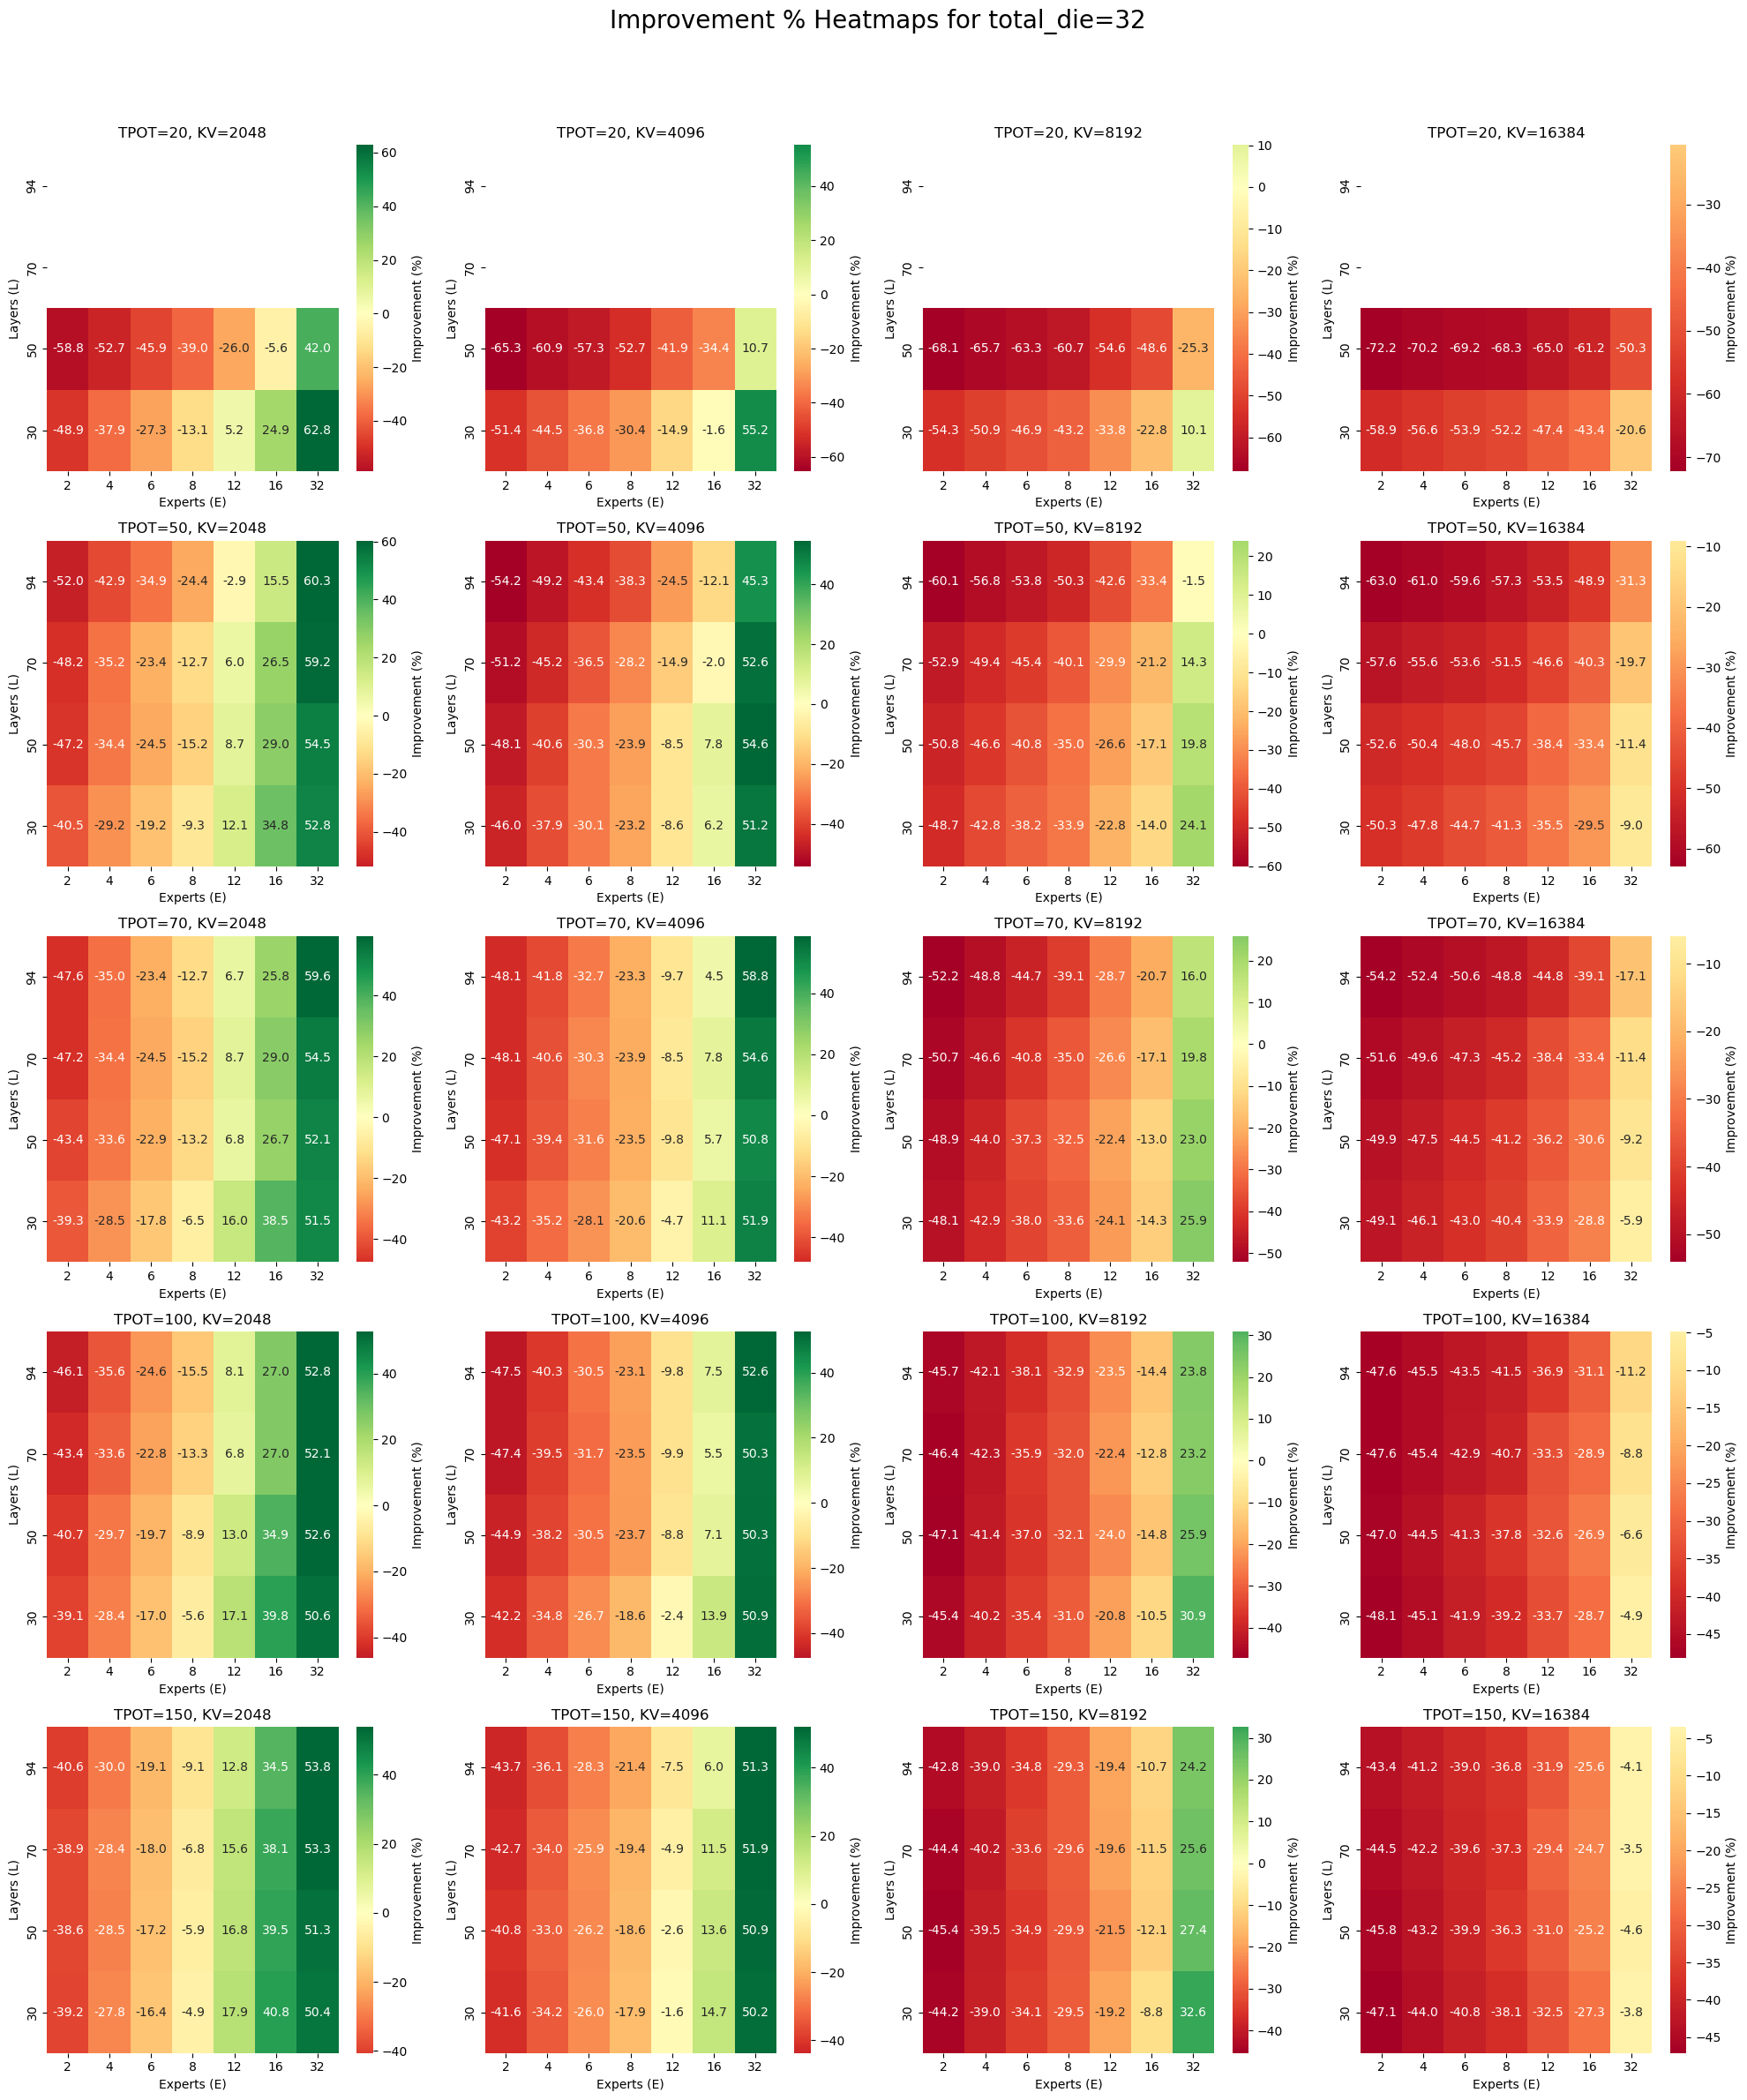

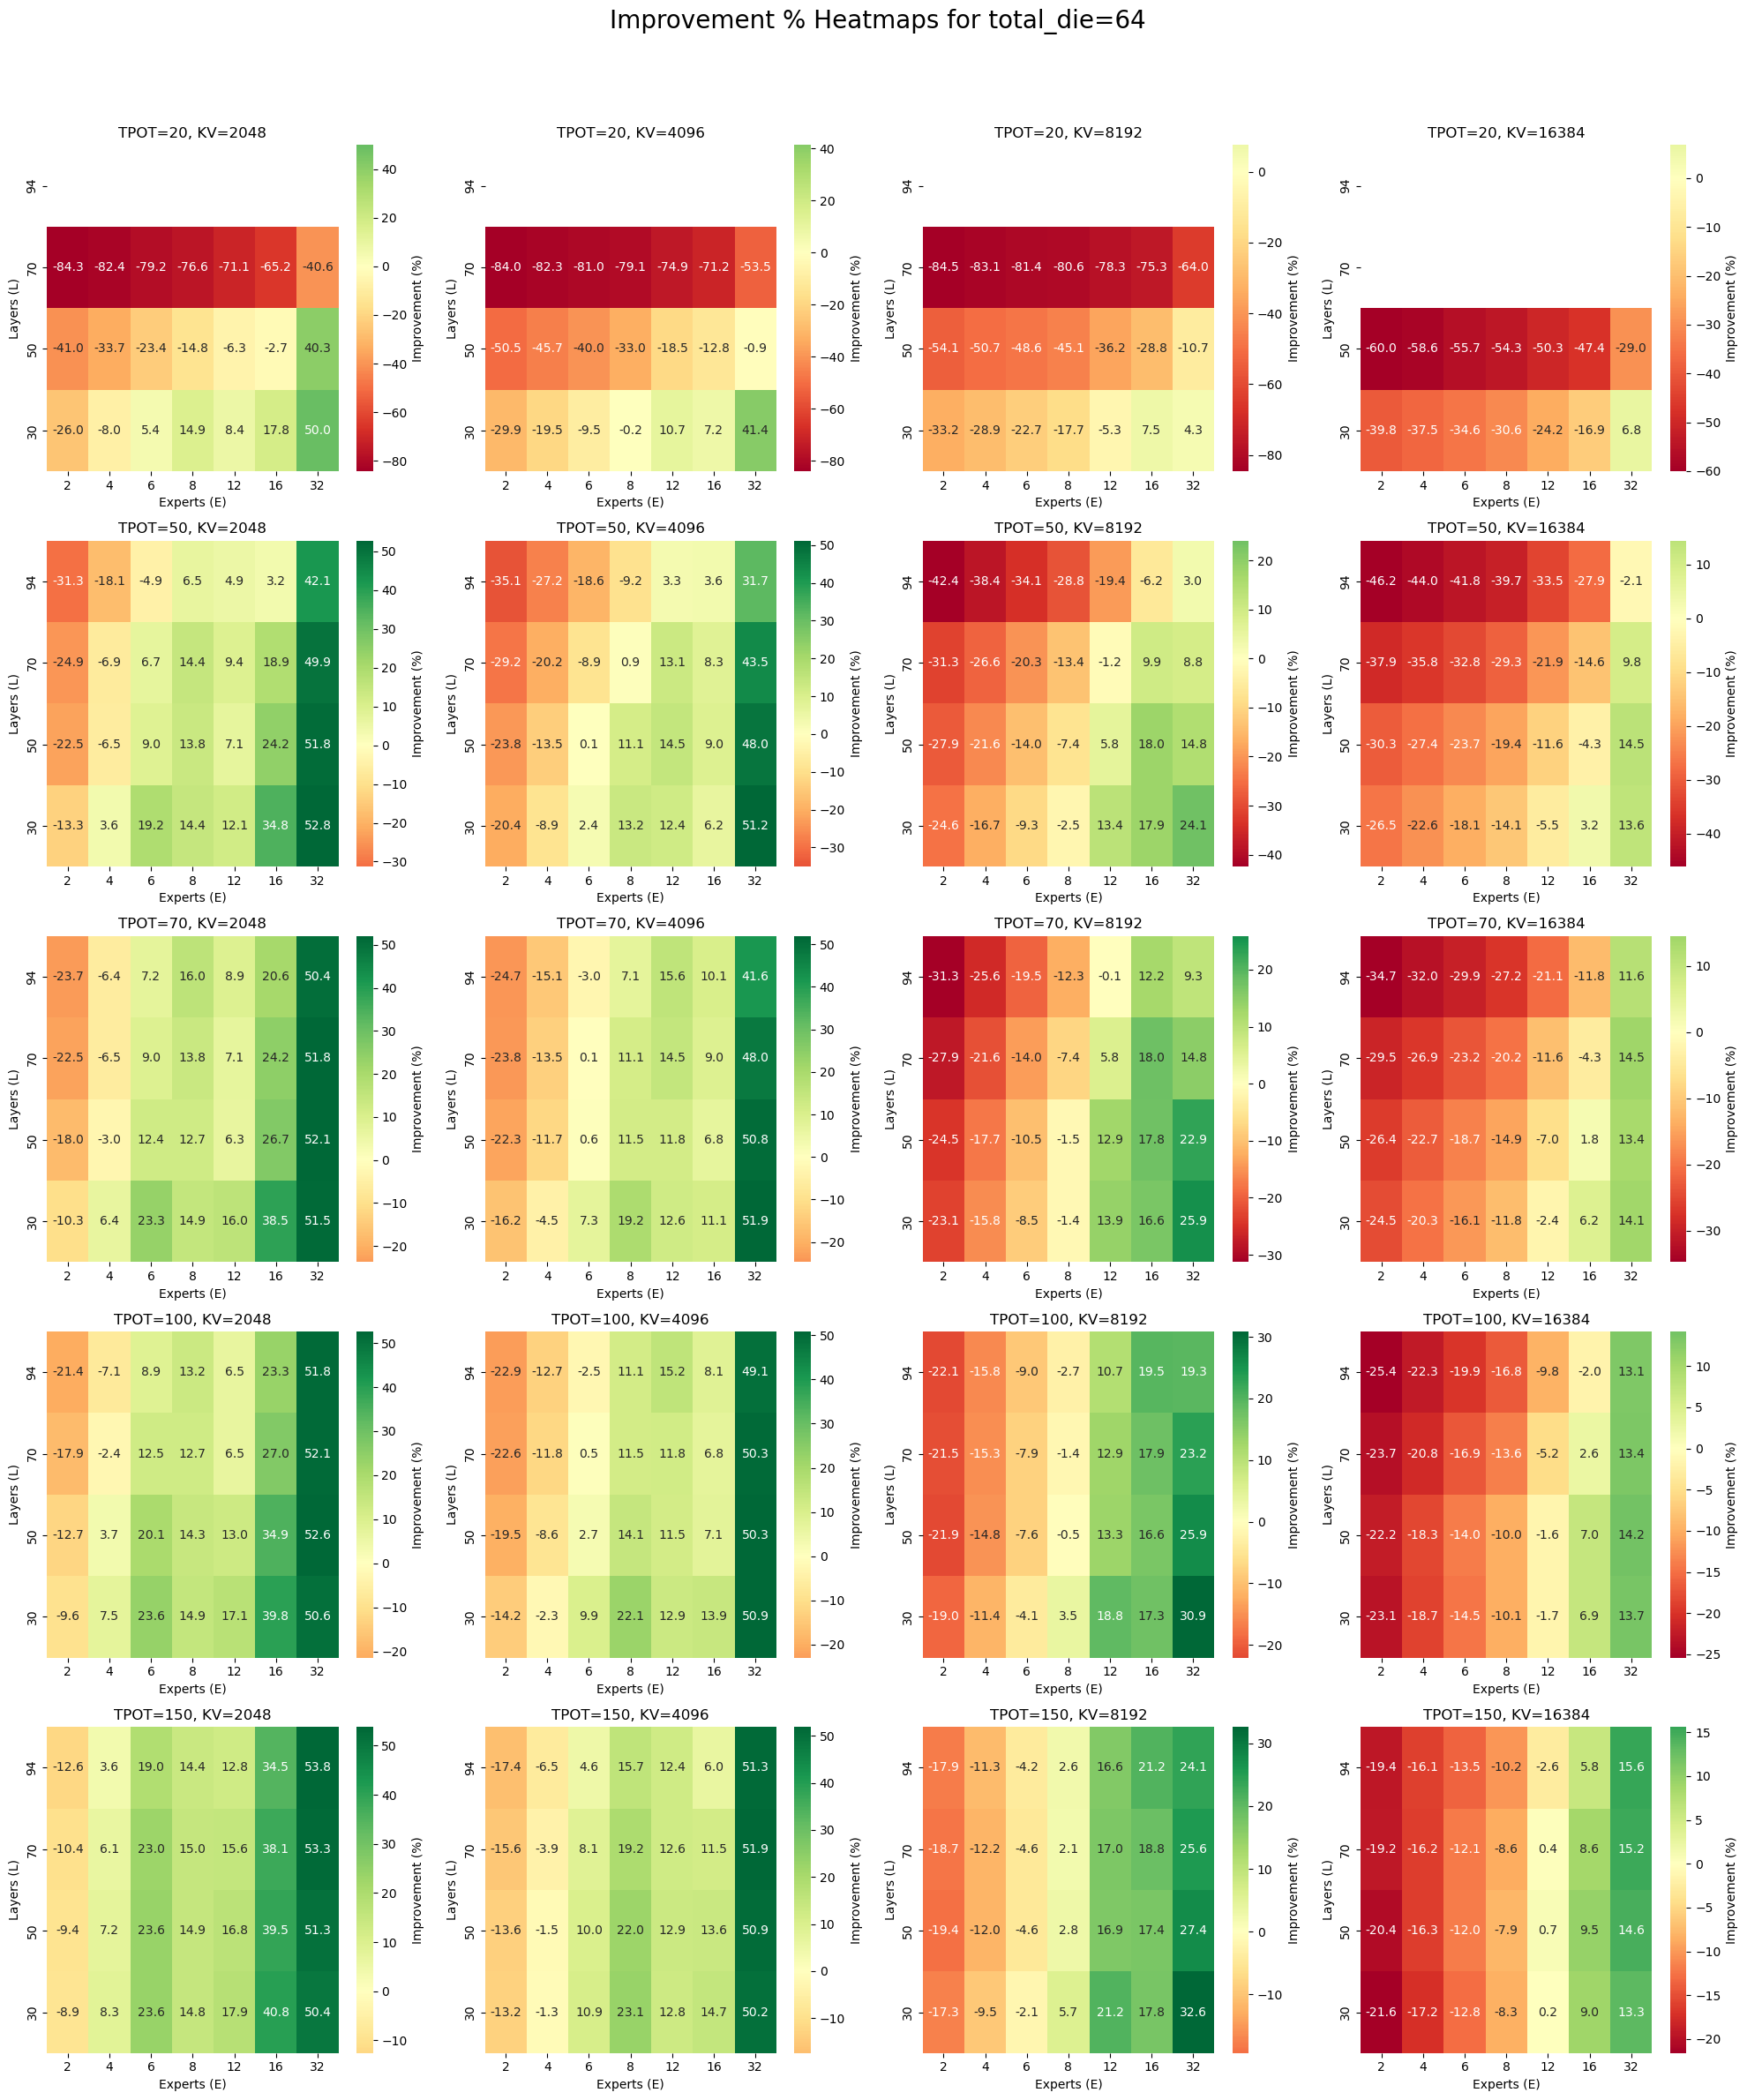

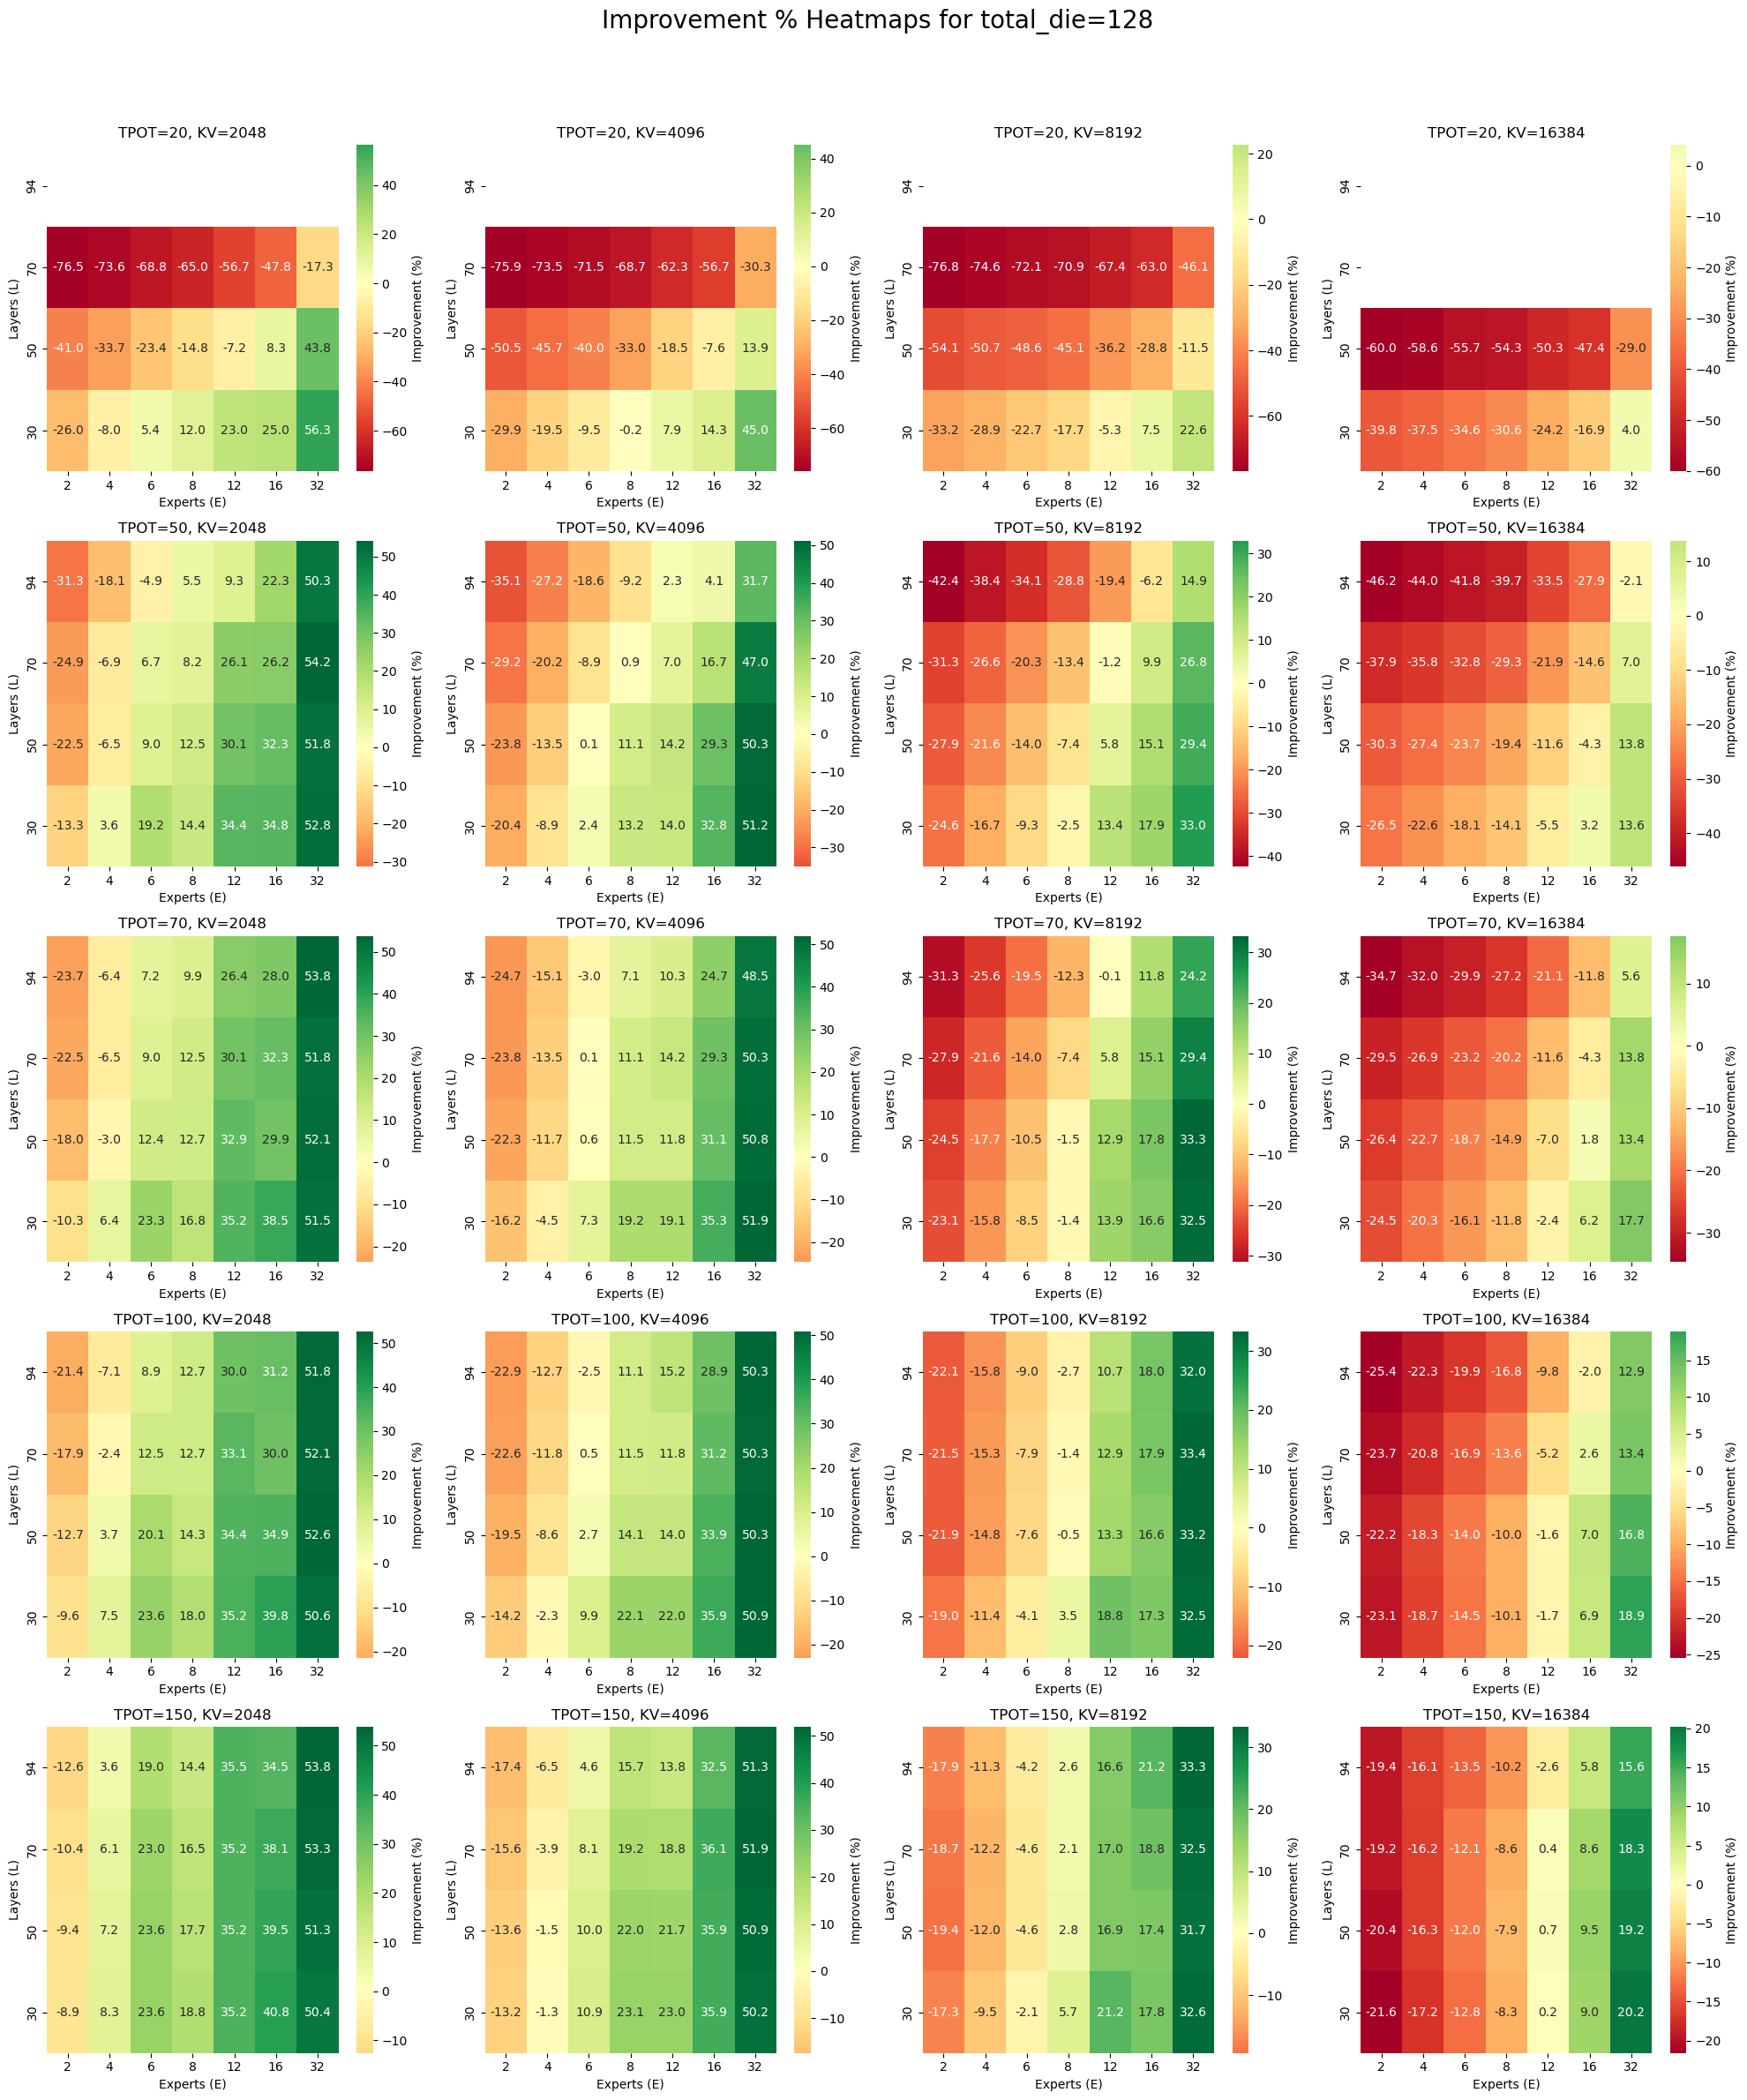

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define parameters for iteration
target_base_model = 'QWEN3_235B'
E_list = [2, 4, 6, 8, 12, 16, 32]
L_list = [30, 50, 70, 94]
tpot_list = [20, 50, 70, 100, 150]
kv_len_list = [2048, 4096, 8192, 16384]
dies_list = [32, 64, 128]    # 新增对不同die的遍历
target_mbns = 3  # None allows all MBNs, we will take max improvement

for target_dies in dies_list:
    fig, axes = plt.subplots(
        len(tpot_list),
        len(kv_len_list),
        figsize=(len(kv_len_list)*5, len(tpot_list)*5),
        squeeze=False
    )
    plt.subplots_adjust(top=0.90)
    found_any_data = False

    for i, target_tpot in enumerate(tpot_list):
        for j, target_kv_len in enumerate(kv_len_list):
            heatmap_data = pd.DataFrame(index=L_list, columns=E_list, dtype=float)
            has_data = False
            for e in E_list:
                for l in L_list:
                    target_models_name = f"{target_base_model}_E{e}_L{l}"
                    df_tmp = filter_results(
                        final_merged_df,
                        model_name=target_models_name,
                        total_die=target_dies,
                        kv_len=target_kv_len,
                        tpot=target_tpot,
                        micro_batch_num=target_mbns
                    )
                    if not df_tmp.empty:
                        improvement = df_tmp['improvement_percentage'].max()
                        heatmap_data.at[l, e] = improvement
                        has_data = True
                        found_any_data = True

            ax = axes[i, j]
            if has_data:
                sns.heatmap(
                    heatmap_data.sort_index(ascending=False), 
                    annot=True, fmt=".1f", cmap="RdYlGn", center=0, 
                    cbar_kws={'label': 'Improvement (%)'}, ax=ax
                )
            else:
                ax.set_visible(False)
                ax.remove()
                continue
            ax.set_title(f'TPOT={target_tpot}, KV={target_kv_len}')
            ax.set_xlabel('Experts (E)')
            ax.set_ylabel('Layers (L)')

    if found_any_data:
        plt.suptitle(f'Improvement % Heatmaps for total_die={target_dies}', fontsize=20)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print(f"No data found for Die={target_dies}, skipping big plot.")

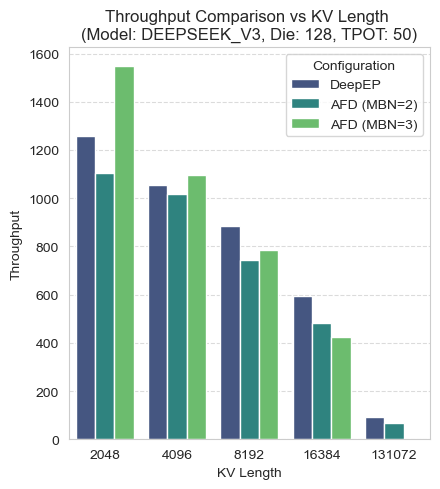

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_throughput_by_kv_mbn(df):
    if df.empty:
        print("DataFrame is empty.")
        return

    # Get unique dies present in the filtered result
    dies = sorted(df['total_die'].unique())
    
    for die in dies:
        subset = df[df['total_die'] == die].copy()
        if subset.empty: continue
        
        # Restructure data to include DeepEP as a separate category
        plot_data = []
        kv_lens = sorted(subset['kv_len'].unique())
        
        for kv in kv_lens:
            kv_subset = subset[subset['kv_len'] == kv]
            if kv_subset.empty: continue
            
            # Add DeepEP baseline (one per kv_len)
            # Assuming throughput_deepep is consistent for the same config
            if 'throughput_deepep' in kv_subset.columns:
                deepep_val = kv_subset['throughput_deepep'].iloc[0]
                plot_data.append({
                    'kv_len': kv,
                    'Category': 'DeepEP',
                    'Throughput': deepep_val
                })
            
            # Add AFD values for each MBN
            for _, row in kv_subset.iterrows():
                mbn = row['micro_batch_num']
                afd_val = row['throughput_afd']
                plot_data.append({
                    'kv_len': kv,
                    'Category': f'AFD (MBN={mbn})',
                    'Throughput': afd_val
                })
        
        plot_df = pd.DataFrame(plot_data)
        
        plt.figure(figsize=(4.5, 5))
        # Use barplot with the new structure
        sns.barplot(data=plot_df, x='kv_len', y='Throughput', hue='Category', palette='viridis')
        
        # Title and labels
        model = subset['model_name'].iloc[0] if 'model_name' in subset.columns else 'Unknown Model'
        tpot = subset['tpot'].iloc[0] if 'tpot' in subset.columns else 'Unknown TPOT'
        
        plt.title(f'Throughput Comparison vs KV Length \n(Model: {model}, Die: {die}, TPOT: {tpot})')
        plt.xlabel('KV Length')
        plt.ylabel('Throughput')
        plt.legend(title='Configuration')
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_throughput_by_kv_mbn(deepseek_df_tmp)

Figure saved to image/QWEN3_235B_E8_L94_mbn3_die64_throughput.png


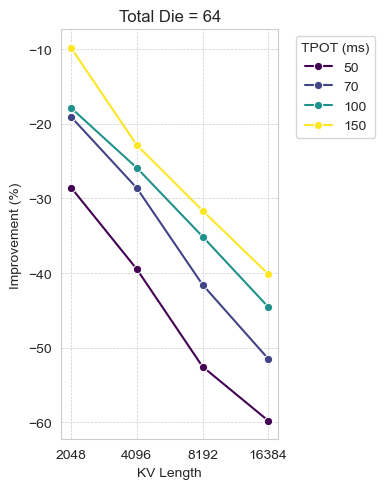

Figure saved to image/QWEN3_235B_E8_L94_mbn3_die128_throughput.png


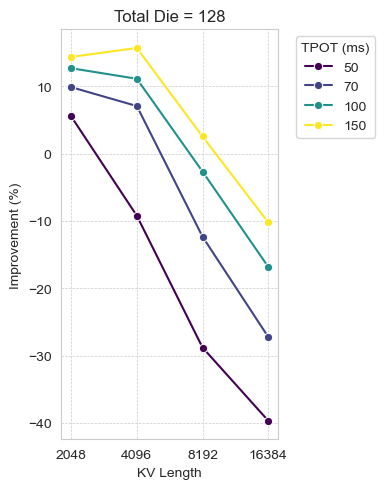

Figure saved to image/QWEN3_235B_E8_L94_mbn3_die256_throughput.png


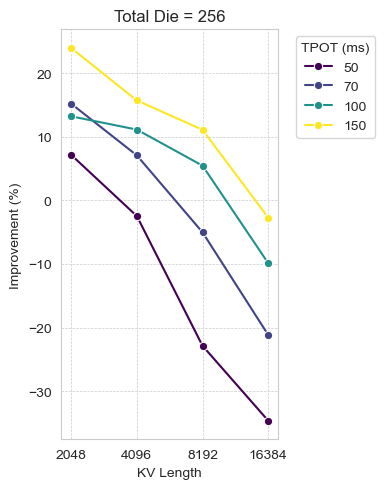

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

def plot_throughput_improvement(model_name, micro_batch_num, total_die_list):
    # Ensure image directory exists
    os.makedirs('image', exist_ok=True)
    
    sns.set_style('whitegrid')
    
    for total_die in total_die_list:
        # Create a new figure for each separate plot
        plt.figure(figsize=(4, 5))
        
        # 1. Get Data
        comparison_df = compare_model_throughput(
            model_name, 
            total_die_filter=total_die, 
            micro_batch_num_filter=micro_batch_num
        )
        
        if comparison_df.empty:
            print(f'No data for Total Die = {total_die}')
            plt.close() # Close empty figure
            continue
            
        # 2. Filter and Process
        plot_df = comparison_df[comparison_df['kv_len'] != 131072].copy()
        plot_df = plot_df.sort_values('kv_len')
        plot_df['kv_len_str'] = plot_df['kv_len'].astype(str)
        
        # 3. Plot
        sns.lineplot(
            data=plot_df, 
            x='kv_len_str', 
            y='improvement_percentage', 
            hue='tpot', 
            palette='viridis',
            marker='o',
            sort=False
        )
        
        # 4. Decoration
        plt.title(f'Total Die = {total_die}', fontsize=12)
        plt.ylabel('Improvement (%)')
        plt.xlabel('KV Length')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend(title='TPOT (ms)', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.tight_layout()
        
        # Save the figure separately for each total_die
        safe_model_name = model_name.replace(' ', '_')
        save_path = f'image/{safe_model_name}_mbn{micro_batch_num}_die{total_die}_throughput.png'
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f'Figure saved to {save_path}')
        
        plt.show()

# Execute the function with specified parameters
# Model: DEEPSEEK_V3, Total Die: [64, 128, 288, 384], MBN: 3
# plot_throughput_improvement('DEEPSEEK_V3', 3, [64, 128, 256])
plot_throughput_improvement('QWEN3_235B_E8_L94', 3, [64, 128, 256])

# plot_throughput_improvement('DEEPSEEK_V3', 2, [64, 128, 256])
# # Model: QWEN3_235B, Total Die: [32, 64, 128, 288, 384], MBN: 3
# plot_throughput_improvement('QWEN3_235B', 3, [32, 64, 128, 288, 384])

# plot_throughput_improvement('M8', 3, [32, 64, 128])

In [48]:
from IPython.display import Image, display
import os

def show_pipeline_image(model_name, tpot, kv_len, mbn, total_die):
    """
    Displays the pipeline visualization image for the specified configuration.
    Path format: data/images/pipeline/{model_name}/tpot{tpot}_kv{kv_len}/mbn{mbn}_die{total_die}.png
    """
    base_path = 'data/images/pipeline'
    # Construct the file path
    # Note: folder structure uses tpot{val}_kv{val}, file uses mbn{val}_die{val}
    rel_path = f"{model_name}/tpot{tpot}_kv{kv_len}/mbn{mbn}_die{total_die}.png"
    full_path = os.path.join(base_path, rel_path)
    
    if os.path.exists(full_path):
        print(f"Displaying: {full_path}")
        display(Image(filename=full_path))
    else:
        print(f"Image not found at: {full_path}")
        # Optional: try to list directory content to help debugging
        dir_path = os.path.dirname(full_path)
        if os.path.exists(dir_path):
             print(f"Available files in {dir_path}: {os.listdir(dir_path)}")
        else:
             print(f"Directory does not exist: {dir_path}")

# Example usage:
# show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=4096, mbn=1, total_die=64)


Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv2048/mbn1_die256.png


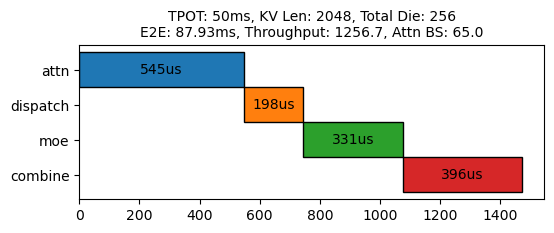

Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv2048/mbn2_die256.png


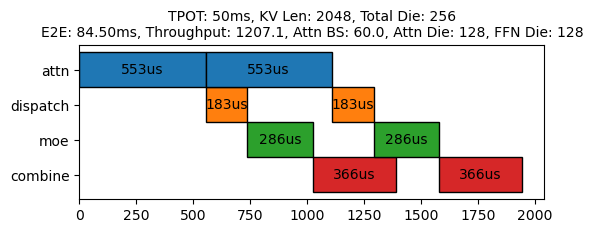

Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv2048/mbn3_die256.png


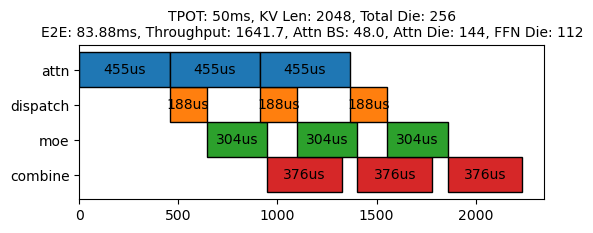

Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv16384/mbn1_die256.png


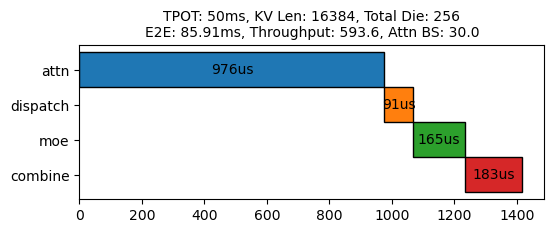

Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv16384/mbn2_die256.png


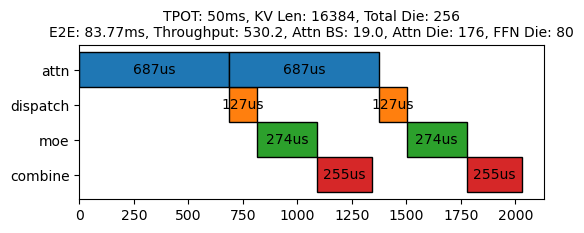

Displaying: data/images/pipeline/DEEPSEEK_V3/tpot50_kv16384/mbn3_die256.png


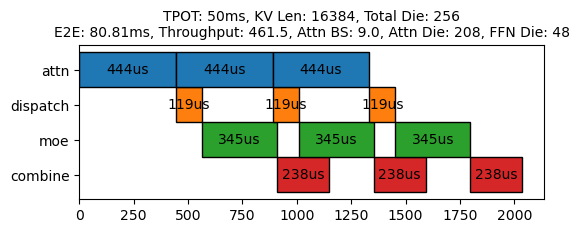

In [53]:
show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=2048, mbn=1, total_die=256)
show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=2048, mbn=2, total_die=256)
show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=2048, mbn=3, total_die=256)

show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=16384, mbn=1, total_die=256)
show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=16384, mbn=2, total_die=256)
show_pipeline_image(model_name='DEEPSEEK_V3', tpot=50, kv_len=16384, mbn=3, total_die=256)

# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=1, total_die=64)
# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=2, total_die=64)
# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=3, total_die=64)

# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=1, total_die=64)
# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=2, total_die=64)
# show_pipeline_image(model_name='QWEN3_235B_E32_L94', tpot=50, kv_len=2048, mbn=3, total_die=64)